In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt


from torch.distributions.multivariate_normal import MultivariateNormal



import numpy as np



from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [4]:

batch_size = 100
take_latent_max =10
num_epoch = 10
input_width = 28
#input_dim=28*28
input_dim=7*7*64
output_dim=input_dim
en_hidden1_dim = 500
en_hidden2_dim = 500
en_hidden3_dim = 2000
latent_dim= 10
de_hidden1_dim = 2000
de_hidden2_dim = 500
de_hidden3_dim = 500

mi_hidden1_dim = 1000
mi_hidden2_dim = 1000

input_ch = 1
nch1 =32
kernel1 = 4
stride1 = 2
padding1 = 1
dilation1 = 1

out_width1 = int((input_width+2*padding1-kernel1)/stride1 + 1)

nch2 = nch1*2
kernel2 = kernel1
stride2 = stride1
padding2 = padding1
dilation2 = dilation1

out_width2 = int((out_width1+2*padding2-kernel2)/stride2 + 1)

nch3 = nch2*2
kernel3 = 3
stride3 = stride2
padding3 = padding2
dilation3 = dilation2

out_width3 = int((out_width2+2*padding3-kernel3)/stride3 + 1)

nch4 = nch3*2
kernel4 = 4
stride4 = 1
padding4 = 0
dilation4 = dilation3

out_width4 = int((out_width3+2*padding4-kernel4)/stride4 + 1)

tnch4 = nch4
tkernel4 = kernel4
tstride4 = stride4
tpadding4 = padding4
tdilation4 = dilation4

tout_width4 = int((out_width4-1)*tstride4 -2*tpadding4 + tkernel4)

tnch3 = nch3
tkernel3 = kernel3
tstride3 = stride3
tpadding3 = padding3
tdilation3 = dilation3

tout_width3 = int((out_width3-1)*tstride3 -2*tpadding3 + tkernel3)

tnch2 = nch2
tkernel2 = kernel2
tstride2 = stride2
tpadding2 = padding2
tdilation2 = dilation2

tout_width2 = int((out_width2-1)*tstride2 -2*tpadding2 + tkernel2)

tnch1 = nch1
tkernel1 = kernel1
tstride1 = stride1
tpadding1 = padding1
tdilation1 = dilation1

tout_width1 = int((out_width1-1)*tstride1 -2*tpadding1 + tkernel1)

out_ch = input_ch


log_interval = 600

K_model_cluster = 10
K_real_cluster = 10

beta= 1.
beta_start = beta
beta_end = 1.
total_step = 500
beta_delta = (beta_end-beta_start)/total_step


save_folder = 'SGD-conv-vae-results'

KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

eps_N_c = 0
iter_adiabatic =1

qn_value =0

TC_gamma = 10.

stabilizer_eps = 1.0e-16

In [5]:
tout_width4

4

In [6]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)


In [7]:
def initialize_centers():

    mu_c = torch.randn(1,latent_dim,K_model_cluster,device=device)
    logvar_c = torch.zeros(1,latent_dim,K_model_cluster).to(device)
    inv_sm_pi_c = torch.zeros(1,1,K_model_cluster).to(device)

    return mu_c,logvar_c,inv_sm_pi_c

In [8]:


#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,inv_sm_pi_c_g = initialize_centers()
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_c_g.shape,inv_sm_pi_c_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]), torch.Size([1, 1, 10]))

In [9]:
mu_c_g.requires_grad_(True)
logvar_c_g.requires_grad_(True)
inv_sm_pi_c_g.requires_grad_(True)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       requires_grad=True)

In [10]:
mu_c_g.requires_grad,logvar_c_g.requires_grad,inv_sm_pi_c_g.requires_grad
#F.softmax(inv_sm_pi_c_g,dim=0)

(True, True, True)

In [11]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)##728 => 500 for MNIST
        self.encode1_layer = nn.Linear(en_hidden1_dim,en_hidden2_dim)##500 => 500 for MNIST
        self.encode2_layer = nn.Linear(en_hidden2_dim,en_hidden3_dim)##500 => 2000 for MNIST
        self.mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST
        self.decode2_layer = nn.Linear(de_hidden1_dim,de_hidden2_dim)##2000 => 500 for MNIST
        self.decode3_layer = nn.Linear(de_hidden2_dim,de_hidden3_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(de_hidden3_dim,output_dim)##500 => 728 for MN#%%IST

        self.first_conv = nn.Conv2d(in_channels=input_ch,out_channels=nch1,kernel_size=kernel1,stride=stride1,padding=padding1,dilation=dilation1)
        self.first_bn = nn.BatchNorm2d(nch1)
        self.second_conv = nn.Conv2d(in_channels=nch1,out_channels=nch2,kernel_size=kernel2,stride=stride2,padding=padding2,dilation=dilation2)
        self.second_bn = nn.BatchNorm2d(nch2)
        self.third_conv = nn.Conv2d(in_channels=nch2,out_channels=nch3,kernel_size=kernel3,stride=stride3,padding=padding3,dilation=dilation3)
        self.third_bn = nn.BatchNorm2d(nch3)
        self.fourth_conv = nn.Conv2d(in_channels=nch3,out_channels=nch4,kernel_size=kernel4,stride=stride4,padding=padding4,dilation=dilation4)
        self.fourth_bn = nn.BatchNorm2d(nch4)


        self.conv_mu_layer = nn.Linear(out_width4*out_width4*nch4,latent_dim)##4*4*128 => 10 for MNIST
        self.conv_std_layer = nn.Linear(out_width4*out_width4*nch4,latent_dim)##4*4*128 => 10 for MNIST
        self.conv_latent_decode = nn.Linear(latent_dim,out_width4*out_width4*nch4) # 10 -> 4*4*128

        self.fourth_tconv = nn.ConvTranspose2d(in_channels=tnch4,out_channels=tnch3,kernel_size=tkernel4,stride=tstride4,padding=tpadding4,dilation=tdilation4)
        self.fourth_tbn = nn.BatchNorm2d(tnch3)
        self.third_tconv = nn.ConvTranspose2d(in_channels=tnch3,out_channels=tnch2,kernel_size=tkernel3,stride=tstride3,padding=tpadding3,dilation=tdilation3)
        self.third_tbn = nn.BatchNorm2d(tnch2)
        self.second_tconv = nn.ConvTranspose2d(in_channels=tnch2,out_channels=tnch1,kernel_size=tkernel2,stride=tstride2,padding=tpadding2,dilation=tdilation2)
        self.second_tbn = nn.BatchNorm2d(tnch1)
        self.first_tconv = nn.ConvTranspose2d(in_channels=tnch1,out_channels=out_ch,kernel_size=tkernel1,stride=tstride1,padding=tpadding1,dilation=tdilation1)
        self.first_tbn = nn.BatchNorm2d(out_ch)


    def encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.mu_layer(en_h3), self.std_layer(en_h3)
    #入力から中心と分散の対数を作っている

    def conv_encode(self, x):
        conv_h1 = F.relu(self.first_bn(self.first_conv(x)))  #28*28 -> 14*14*32
        conv_h2 = F.relu(self.second_bn(self.second_conv(conv_h1)))  #14*14*32 -> 7*7*64
        conv_h3 = F.relu(self.third_bn(self.third_conv(conv_h2)))  #7*7*64 -> 4*4*128
        conv_h4 = F.relu(self.fourth_bn(self.fourth_conv(conv_h3)))  #4*4*128 -> 1*1*256
        return self.conv_mu_layer(conv_h4.view(batch_size,out_width4*out_width4*nch4)), self.conv_std_layer(conv_h4.view(batch_size,out_width4*out_width4*nch4))  #1*1*256 -> 10

#    def conv_encode(self, x):
#        conv_h1 = F.relu(self.first_conv(x))  #28*28 -> 14*14*32
#        conv_h2 = F.relu(self.second_conv(conv_h1))  #14*14*32 -> 7*7*64
#        return conv_h2.view(batch_size,out_width2*out_width2*nch2) #フラットにして出す


    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        de_h1 = F.relu(self.decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return self.output_layer(de_h3)
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている


 #   def tconv_decode(self,z):
 #       tconv_h1 = F.relu(self.conv_latent_decode(z))  #10 -> 7*7*64
 #       tconv_h2 = F.relu(self.second_tconv(z.view(-1,tnch2,out_width2,out_width2))) #7*7*64 ->14*14*32
 #       return torch.sigmoid((self.first_tconv(tconv_h2)).squeeze()) #14*14*32 -> 28*28
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている

    def tconv_decode(self,z):
        tconv_h4 = F.relu(self.conv_latent_decode(z))#10 -> 1*1*256
        tconv_h3 = F.relu(self.fourth_tbn(self.fourth_tconv(tconv_h4.view(-1,tnch4,out_width4,out_width4)))) #1*1*256->4*4*128
        tconv_h2 = F.relu(self.third_tbn(self.third_tconv(tconv_h3))) #4*4*128 ->7*7*64
        tconv_h1 = F.relu(self.second_tbn(self.second_tconv(tconv_h2))) #7*7*64 ->14*14*32
        return torch.sigmoid(self.first_tconv(tconv_h1).squeeze()) #14*14*32 -> 28*28
#    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている

#    def forward(self, x):
#        mu, logvar = self.encode(self.conv_encode(x))
#        z = self.reparameterize(mu, logvar)
#        return self.tconv_decode(self.decode(z)),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている

    def forward(self, x):
        mu, logvar = self.conv_encode(x)
        z = self.reparameterize(mu, logvar)
        return self.tconv_decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている


model = VAE().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.002)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


#optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g,inv_sm_pi_c_g],lr=0.002)
optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g],lr=0.002)
scheduler_clustering = torch.optim.lr_scheduler.MultiStepLR(optimizer_clustering,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


In [12]:
def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    mus = torch.cat((mus,mu_c_g.permute(2,1,0)),0)
    ts = torch.cat((ts,torch.arange(-1,-K_model_cluster-1,-1).to(device)),0)
    return zs,ts,mus,logvars


In [13]:
def gauss(mus,logvars,mu_c,logvar_c,inv_sm_pi_c,iter):

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2))/(logvar_c.exp())

            gamma_c = (F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp()))/((F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = (((F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P


In [14]:
def drawpoints(mus_numpy,ts_numpy):
    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(points,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,center_numpy,center_t_numpy):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color='black',s=50)

#    plt.xlim(-4,4)
#    plt.ylim(-4,4)
    plt.show()

In [15]:
N_wide = 10
N_sigma =7
def show_generated_samples_c(mu_c,logvar_c):

    for i in range(K_model_cluster):
        sample = torch.empty(latent_dim*(N_wide+1),latent_dim).to(device)
        with torch.no_grad():
            for j in range(latent_dim):
                for k in range(N_wide+1):
                    std_c =torch.zeros(latent_dim).to(device)
                    std_c[j] = (logvar_c_g[0,j,i].exp()).sqrt()
                    sample[j*(N_wide+1)+k,:] = mu_c[0,:,i]+N_sigma*(k-N_wide/2)*std_c/N_wide
            #sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            #sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.tconv_decode(sample).cpu()
            #sample = model.tconv_decode(model.decode(sample)).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(latent_dim*(N_wide+1),1,28,28),save_folder+'/sample_c_' + str(i) + '.png',nrow=N_wide+1)
        #生成した６４個のデータを記録しておく

In [16]:
def q_exponential(x,n):
    if n==0:
        return x.exp()
    else:
        return (1. - x/n).pow(-n)

def q_log(x,n):
    if n==0:
        return x.log()
    else:
        return n*(x.pow(1./n)-1.)

In [17]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,inv_sm_pi_c_f):
    BCE = F.binary_cross_entropy(recon_x.view(-1,input_dim),x.view(-1,input_dim),reduction='sum')
    KLD = -(q_log(stabilizer_eps+(F.softmax(inv_sm_pi_c_f,dim=2)*(q_exponential(-0.5*((-1.+logvar_c_f-logvars_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True)),qn_value))).sum(2,keepdim=True),qn_value)).sum()

    return BCE+beta*KLD


In [18]:
def train_c(epoch,mu_c,logvar_c,inv_sm_pi_c):
    model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        optimizer_clustering.zero_grad()

        #傾きの初期化
        recon_batch, mu, logvar,z_data = model(data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る

        loss = loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,inv_sm_pi_c_f=inv_sm_pi_c)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #NNパラメータの更新

        optimizer_clustering.step()
        #NNクラスタリングパラメータの更新


#        print(mu_c_g)
#        print('var_c='.format(logvar_c_g.exp()))

#        print('mu={}'.format(mu.view(-1,latent_dim,1).squeeze()))
#        print('prec_c={}'.format((1./logvar_c_g.exp()).squeeze()))
#        print('quad={}'.format(((((mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1)).squeeze()))
#        print('quadvar={}'.format((((logvar.view(-1,latent_dim,1).exp())/(logvar_c_g.exp())).sum(1)).squeeze()))
#        print('expDKL={}'.format((-0.5*((logvar_c_g+(logvar.view(-1,latent_dim,1).exp()+(mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1,keepdim=True))).exp().squeeze()))
#        print('logDKL={}'.format((((F.softmax(inv_sm_pi_c_g,dim=2)*((-0.5*((logvar_c_g+(logvar.view(-1,latent_dim,1).exp()+(mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1,keepdim=True))).exp())).sum(2,keepdim=True)).log()).squeeze()))

        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

#        if batch_idx == 5:
#            break

In [19]:
def test_c(epoch,mu_c,logvar_c,inv_sm_pi_c):
    model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z_data = model(data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,inv_sm_pi_c_f=inv_sm_pi_c).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [20]:
'''
def train_c_epoch(epochs,mu_c,logvar_c,inv_sm_pi_c):
    for epoch in range(1, epochs +1):
        train_c(epoch,mu_c,logvar_c,inv_sm_pi_c)
        test_c(epoch,mu_c,logvar_c,inv_sm_pi_c)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

'''

"\ndef train_c_epoch(epochs,mu_c,logvar_c,inv_sm_pi_c):\n    for epoch in range(1, epochs +1):\n        train_c(epoch,mu_c,logvar_c,inv_sm_pi_c)\n        test_c(epoch,mu_c,logvar_c,inv_sm_pi_c)\n        with torch.no_grad():\n            sample = torch.randn(64,latent_dim).to(device)\n        #20次元の潜在空間のデータを64個作成して、GPUに送る\n            sample = model.decode(sample).cpu()\n        #ランダムな潜在変数から画像を生成する。\n            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)\n        #生成した６４個のデータを記録しておく\n\n"

In [21]:

mu_c_g,logvar_c_g,F.softmax(inv_sm_pi_c_g,dim=2)

(tensor([[[ 0.4519, -0.3219,  2.5174, -2.3789, -0.5193,  1.2967,  1.4071,
            1.1582, -2.5024,  1.3282],
          [ 0.8141,  0.9535, -0.3471, -0.0662, -0.0887, -0.4486, -0.6486,
           -0.1566,  0.4525, -0.7346],
          [ 0.3074,  1.3153,  1.4545,  1.7507, -0.0511,  0.1216,  2.0988,
            0.7314, -0.4840,  1.9580],
          [-1.0150, -1.6722, -0.9606, -0.6719, -1.3621, -0.0704, -0.0508,
            0.3868, -0.3654,  1.2156],
          [ 0.4578, -0.6063, -1.0672,  0.9901, -0.0712, -0.3948, -1.3406,
            0.4382,  1.3012, -0.2782],
          [ 1.0010, -2.1101, -0.3539, -1.7692, -0.6056, -1.8551,  1.0525,
           -0.5902, -1.5097, -0.0259],
          [-0.3756, -0.1100, -1.2002, -0.5655, -1.3940,  0.8034,  1.2671,
            1.1770, -0.6734,  1.7142],
          [-1.0369,  0.0130, -1.2211, -1.4355, -0.5050,  0.1097,  1.2729,
            0.3484,  1.2638, -0.7612],
          [-0.0506, -0.8390,  0.1964, -1.0383, -1.3206, -1.8094,  0.8003,
           -1.2222, -2

In [93]:
#infomax_alpha = 2.
#beta_delta = 0.04
stabilizer_eps = 1.0e-32

In [94]:
for i in range(90):
    #train_c_epoch(epochs=1,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)

    train_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,inv_sm_pi_c=inv_sm_pi_c_g)
    test_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,inv_sm_pi_c=inv_sm_pi_c_g)
    scheduler.step()
    scheduler_clustering.step()

    beta += beta_delta


Train Epoch: 0 [0/60000 (0%)]	Loss: 90.881582
====> Test set loss: 0.9978
Train Epoch: 1 [0/60000 (0%)]	Loss: 92.122920
====> Test set loss: 0.9380
Train Epoch: 2 [0/60000 (0%)]	Loss: 89.457959
====> Test set loss: 0.9242
Train Epoch: 3 [0/60000 (0%)]	Loss: 93.650088
====> Test set loss: 0.9624
Train Epoch: 4 [0/60000 (0%)]	Loss: 87.332734
====> Test set loss: 0.9059
Train Epoch: 5 [0/60000 (0%)]	Loss: 91.842617
====> Test set loss: 0.8757
Train Epoch: 6 [0/60000 (0%)]	Loss: 90.945273
====> Test set loss: 0.9445
Train Epoch: 7 [0/60000 (0%)]	Loss: 89.106699
====> Test set loss: 0.9600
Train Epoch: 8 [0/60000 (0%)]	Loss: 89.830605
====> Test set loss: 0.9913
Train Epoch: 9 [0/60000 (0%)]	Loss: 93.293340
====> Test set loss: 0.9374
Train Epoch: 10 [0/60000 (0%)]	Loss: 87.144707
====> Test set loss: 0.9214
Train Epoch: 11 [0/60000 (0%)]	Loss: 89.878516
====> Test set loss: 0.9211
Train Epoch: 12 [0/60000 (0%)]	Loss: 92.678828
====> Test set loss: 0.9764
Train Epoch: 13 [0/60000 (0%)]	Loss

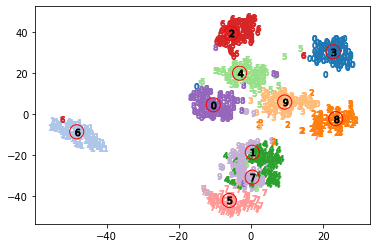

In [95]:
zs_g,ts_g,mus_g,logvars_g = take_latents()
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())
data_points = points[0:take_latent_max*batch_size]
center_points = points[take_latent_max*batch_size:]
data_labels = ts_g[0:take_latent_max*batch_size].cpu().detach().numpy()
center_labels = (-ts_g[take_latent_max*batch_size:]-1).cpu().detach().numpy()
drawpoints_with_centers(data_points,data_labels,center_points,center_labels)

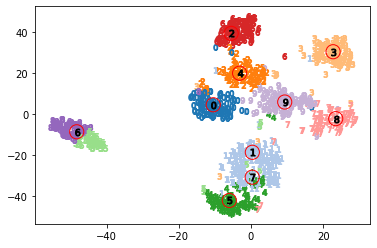

In [96]:
#kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,kmeans_model.labels_)
kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,kmeans_model.labels_[:take_latent_max*batch_size],center_points,center_labels)

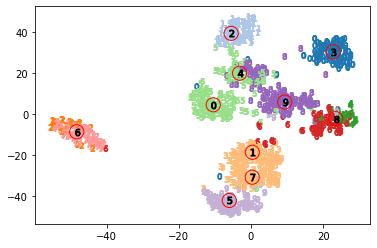

In [97]:
#gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy()))
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy())[:take_latent_max*batch_size],center_points,center_labels)

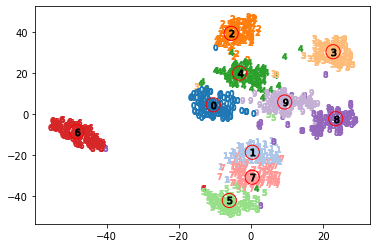

In [98]:

_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,inv_sm_pi_c_g,1)
#drawpoints(points[0:batch_size*take_latent_max,:],torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy())
#_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,chol_prec_seed_c_g,inv_sm_pi_c_g,1)
drawpoints_with_centers(data_points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy(),center_points,center_labels)

In [99]:
show_generated_samples_c(mu_c_g,logvar_c_g)

In [100]:
optimizer.param_groups[0]['lr'],optimizer_clustering.param_groups[0]['lr'],beta

(0.000774840978, 0.000774840978, 1.0)

In [101]:
correspond_matrix = torch.zeros(K_real_cluster,K_model_cluster)

for i in range(batch_size*take_latent_max):

    for j in range(K_model_cluster):
        for k in range(K_real_cluster):
            if torch.argmax(gamma_c_g,2)[i,0] == j:
                if ts_g[i] == k:
                    correspond_matrix[k,j] +=1


In [102]:
correspond_matrix

tensor([[  0.,   0.,   0., 103.,   0.,   0.,   0.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0., 106.,   0.,   1.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  90.,   2.],
        [  0.,   0.,   0.,   0.,   2.,   2.,   0.,   0.,   4.,  90.],
        [  0.,  47.,   0.,   0.,   0.,   0.,   0.,  39.,   0.,   0.],
        [  0.,   0.,   1.,   0.,  97.,   0.,   0.,   1.,   0.,   2.],
        [  0.,   0., 103.,   2.,   1.,   0.,   1.,   0.,   0.,   0.],
        [  0.,   1.,   0.,   0.,   0.,  88.,   0.,   2.,   3.,   0.],
        [103.,   0.,   0.,   2.,   1.,   0.,   0.,   1.,   0.,   1.],
        [  3.,  36.,   0.,   0.,   0.,   2.,   1.,  61.,   0.,   0.]])

In [103]:
correspond_matrix.sum()

tensor(1000.)

In [104]:
torch.max(correspond_matrix,0)

torch.return_types.max(
values=tensor([103.,  47., 103., 103.,  97.,  88., 106.,  61.,  90.,  90.]),
indices=tensor([8, 4, 6, 0, 5, 7, 1, 9, 2, 3]))

In [105]:
torch.max(correspond_matrix,0).values.sum()/(batch_size*take_latent_max)

tensor(0.8880)

In [106]:
F.softmax(inv_sm_pi_c_g,dim=2)

tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [107]:
mu_c_g

tensor([[[ 4.1766,  1.2794,  2.0448,  1.8124, -1.2178,  0.3685, -2.2559,
           2.7941, -1.0848, -1.8345],
         [ 0.4683,  4.4430, -0.7916,  1.6467, -2.2073, -1.9283, -2.2771,
           0.3908,  1.5133, -2.4267],
         [ 3.0438,  1.2078,  2.6584, -1.2541,  2.0196,  2.1135, 11.9986,
           4.0097, -0.4545,  0.6805],
         [-2.1199,  1.2205, -2.3947, -3.6577, -0.2884,  0.2107, -2.3320,
           1.5012, -2.2464,  0.1152],
         [ 2.2693,  0.1511,  3.2310,  0.3405,  0.4737, -2.7026, -1.8313,
           0.1952,  0.1948, -1.6497],
         [ 3.4524, -3.6643, -1.6920, -1.2708,  4.9711, -4.5605, -1.3373,
          -3.0972, -1.7511,  2.9290],
         [ 2.6775, -1.5704, -5.2442, -1.1618, -2.7662,  4.6146,  1.8863,
          -0.3348,  4.2976,  3.7148],
         [-0.0753,  1.4662, -1.8115, -6.9893, -1.5518,  1.3276,  4.0604,
           1.4161,  0.2670, -3.8923],
         [-0.6172, -2.6232,  2.9323, -1.6735, -1.1642, -5.8052,  2.1750,
          -4.4045,  4.5038,  0.9325],
 

In [108]:
logvar_c_g.exp()

tensor([[[ 6.2353,  6.8483,  2.9430,  6.4764,  8.1347,  4.5249,  1.9957,
           3.2636,  8.6576,  3.2851],
         [ 3.7001,  4.6632,  2.0747,  2.1944,  4.7797,  6.4492,  4.6076,
           5.5947,  9.3341,  4.9932],
         [ 8.6723,  9.3825, 12.6874, 10.8938,  6.8628,  7.7339,  5.7108,
           5.7204,  5.4511,  5.9584],
         [ 5.2746,  7.8952,  2.7902,  4.4782,  4.2023,  2.3782,  1.9842,
           5.9632,  4.4929,  2.9813],
         [ 4.3621,  4.6296,  4.2430,  6.0736,  5.0670,  6.0848,  8.8213,
           3.4399,  6.2654,  5.3615],
         [ 4.0034,  2.8274,  7.0865,  4.2614,  5.7396,  2.1044,  2.1803,
           2.1146,  7.1165,  3.3804],
         [ 2.7616,  4.8046,  2.1392,  3.0710,  2.3403,  8.5943,  3.1834,
           2.7200,  9.7666,  4.6452],
         [ 5.4427,  2.9133,  4.3171,  2.4925, 13.9650,  5.8118,  4.4909,
           2.5959,  7.0281,  6.4740],
         [ 4.2275,  6.1786,  1.6932,  3.1149,  5.7144,  8.6412,  4.4289,
           3.8979,  8.0921,  5.0750],
 

In [109]:
mus_g[0:10,:,0]

tensor([[-0.3540, -0.1322,  0.4025,  1.6991,  5.9922,  9.2032, -1.4162, -2.5785,
         -2.2705,  4.0928],
        [ 1.5310, -2.5301, -0.3573, -0.7365,  5.1404,  1.0011, -1.4836, -7.1931,
         -0.9637,  2.2266],
        [ 2.5087, -0.4400,  5.9487,  2.1762,  1.5674, -3.7181,  2.0860,  0.6072,
         -5.3711, -2.5971],
        [ 6.1169,  1.6651, -0.8181,  0.3696, -0.8803, -3.1851, 11.8216,  0.1126,
          3.8271,  2.8213],
        [ 4.8938, -0.7185, -0.3722, -5.1232,  4.4843,  4.9866,  0.8652, -0.0163,
          5.0164,  1.3694],
        [ 5.3181,  3.6653,  3.2678, -1.3718,  2.6361,  2.9558,  3.5512, -0.2719,
         -0.1956, -3.4185],
        [ 2.8085,  1.8524,  3.1131,  0.4536, -0.0899, -2.8373, -1.3075,  0.9883,
         -4.9890,  5.7762],
        [ 0.1985, -0.8985, -0.5893,  1.0399, -4.0840,  2.4628,  5.5135, -3.0560,
          4.2161,  6.7464],
        [ 0.8925,  2.4489, -2.1689,  1.8365, -2.6273, -0.0278,  2.4155, -1.8970,
          7.2966,  0.1539],
        [-0.7483, -

In [110]:
logvars_g.exp()[0:10,:,0]

tensor([[0.2805, 0.1928, 0.0704, 0.1967, 0.1244, 0.1982, 0.1714, 0.0871, 0.1489,
         0.1753],
        [0.1754, 0.1300, 0.0427, 0.1521, 0.0939, 0.0840, 0.1134, 0.1173, 0.1217,
         0.1025],
        [0.2732, 0.1054, 0.1023, 0.2030, 0.2181, 0.3145, 0.2425, 0.2427, 0.1525,
         0.0823],
        [0.2520, 0.3026, 0.1658, 0.3397, 0.2597, 0.1283, 0.3196, 0.2234, 0.1430,
         0.1905],
        [0.1223, 0.1645, 0.0473, 0.1235, 0.1296, 0.0956, 0.0759, 0.0566, 0.1590,
         0.1207],
        [0.1863, 0.1875, 0.0816, 0.1608, 0.1737, 0.1006, 0.1617, 0.1066, 0.1276,
         0.0901],
        [0.1901, 0.1453, 0.0507, 0.1327, 0.2311, 0.2532, 0.1906, 0.2287, 0.1418,
         0.1133],
        [0.2006, 0.2068, 0.0883, 0.2102, 0.2159, 0.1211, 0.1388, 0.0762, 0.1233,
         0.1481],
        [0.0746, 0.0892, 0.0503, 0.0930, 0.1153, 0.0517, 0.0659, 0.0552, 0.1445,
         0.0678],
        [1.6264, 0.7806, 0.9652, 1.6882, 1.1132, 1.2273, 1.0583, 0.7014, 0.7461,
         0.1760]], device='c

In [ ]:
'''
torch.save(
    {
        "model_state_dict" : model.state_dict(),
        "optimizer" : optimizer.state_dict(),
        "optimizer_clustering" : optimizer_clustering.state_dict(),
        "mu_c_g" : mu_c_g,
        "logvar_c_g" : logvar_c_g,
        "inv_sm_pi_c_g" : inv_sm_pi_c_g,
        "beta" : beta,
        "K_model_cluster": K_model_cluster
    },
    "./SGD-q-exponential/model/success949.tar"
)
'''
#sdata966 = torch.load("./SGD-q-exponential/model/success966.tar")
#mu_c_g = sdata966["mu_c_g"]